<a href="https://colab.research.google.com/github/AndreaMagnanini/AI-School/blob/main/LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

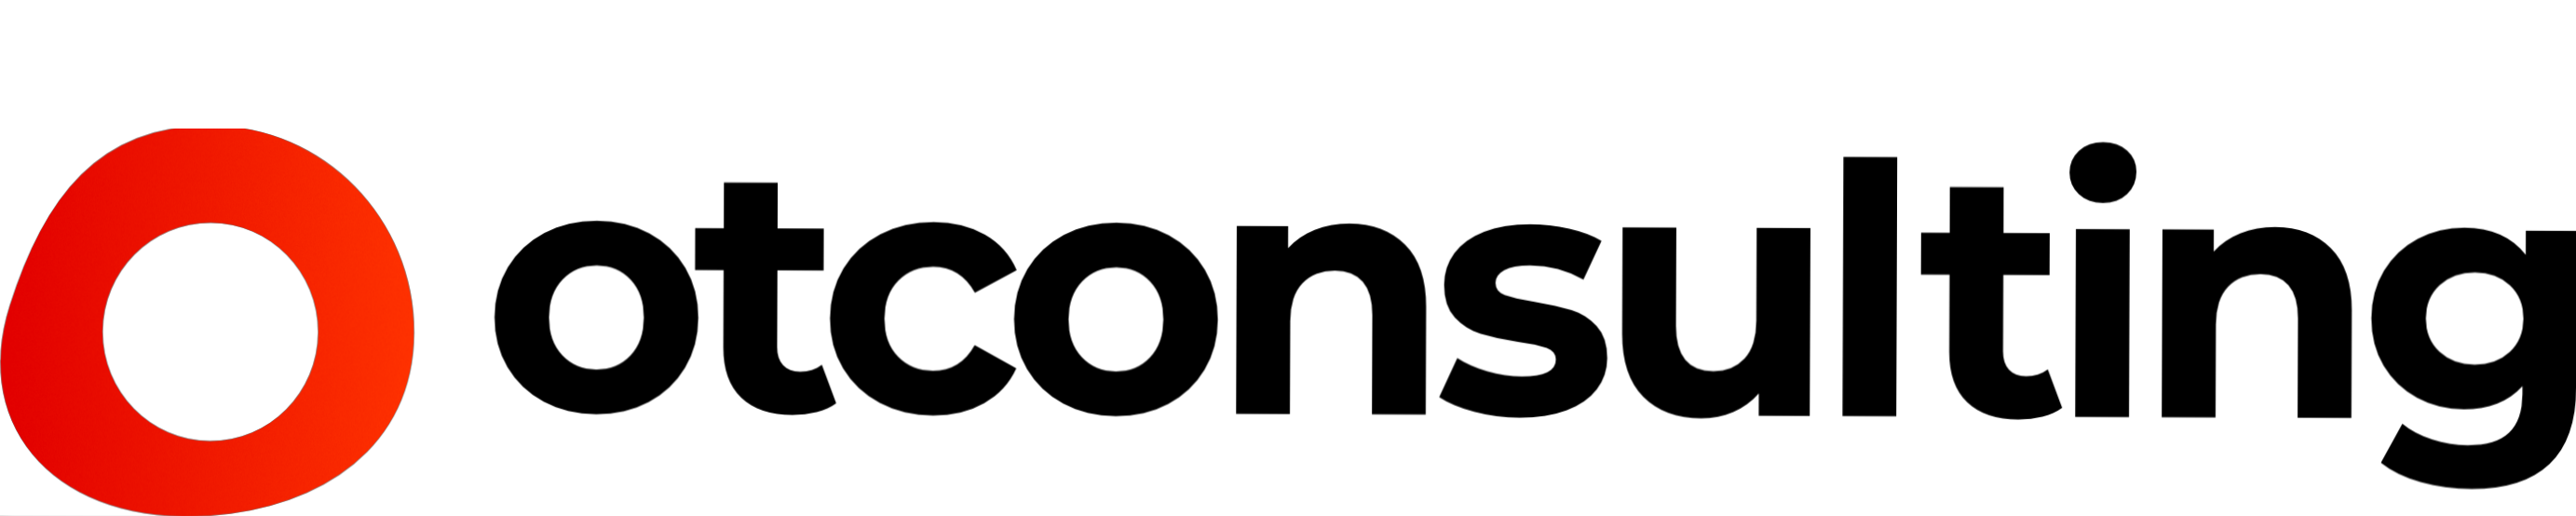

________________________________________________________________________________________________________________________________________________________________
\begin{align}
  \text{}
\end{align}
\begin{align}
  \text{Progetto di}
\end{align}
\begin{align}
  \text{}
\end{align}
\begin{align}
  \huge \text{ Scaltriti Federico}
\end{align}
\begin{align}
  \text{}
\end{align}
\begin{align}
  \huge \text{ Magnanini Andrea}
\end{align}
\begin{align}
  \text{}
\end{align}
\begin{align}
 \text{per il Corso di Perfezionamento}
\end{align}
\begin{align}
  \text{}
\end{align}
<center>
<a href="https://aischools.it/"><img src="https://aischools.it/wp-content/uploads/2021/08/ai-logo.svg" width=400 /></a>
</center>
________________________________________________________________________________________________________________________________________________________________

<div id="header" width=100%>
<table class="tfo-notebook-buttons" align="left" >
  <td>
    <a href="https://keras.io/"><img src="https://keras.io/img/logo.png" width="2050" >
      </a>
  </td>
  <td>
  <a href="https://www.tensorflow.org/"><img src="https://www.gstatic.com/devrel-devsite/prod/v24d520161c9661e427a3f6fa9973bfca56d0972dca82fa8ef65c709d915e80f3/tensorflow/images/lockup.svg"  width=2750 /></a>
  </td>
  <td>
     <a href="https://numpy.org/" ><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/NumPy_logo_2020.svg/2560px-NumPy_logo_2020.svg.png" width=1700 /></a>
  </td> 
  <td>
    <a href="https://pandas.pydata.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Pandas_logo.svg/2560px-Pandas_logo.svg.png" /></a>
  </td>
  <td>
    <a href="https://matplotlib.org/stable/index.html#"><img src="https://matplotlib.org/stable/_images/sphx_glr_logos2_003.png" width=2400 />
      </a>
  </td>
</table>
</div>


# <h1><center>Local Interpretable Model-Agnostic Explainations (LIME)</center></h1>

<h4>Rientra nell'insieme di tecniche di Visual Explanation. Consente di identificare un modello interpretabile data una rappresentazione localmente attendibile.
 </h4>


<center>
<a href="https://github.com/marcotcr/lime"><img src="https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png"></a>
</center>


LIME opera su input approssimati $x'$ chiamati "interpretable input" e il mapping $x = h_x(x')$ converte un vettore binario di \textit{interpretable inputs}
nello spazio degli input originali. Sono usati tipi differenti di mappature $h_x$ in base agli spazi di input originali.

Considerato $g \in G$ un modello preso tra i potenziali modelli interpretabili, avente come dominio $D: \{0, 1\}^d$;

Data $\Omega(g)$ la misura di complessità del modello $g \in G$, come può essere la profondità di un Decision Tree o il numero di pesi diversi da zero in un modello lineare;

Dato $f$ il modello da interpretare e $f(x)$ la sua conseguente predizione;

Data $\pi_x(z) = e^\frac{-D(x, z)^2}{\sigma^2}$ la misura di prossimità tra l'istanza $z$ e $x$, e $D$ la funzione della misura di distanza (come *cosine similarity* o *L2*), avente il ruolo di pesare lo spazio degli input semplificato;

Si determina la misura $L(f, g, \pi_x)$ di quanto $g$ sia attendibile nell'approssimazione di $f$ nella località di $x$ e si punta a minimizzare la seguente funzione obiettivo: \\

\begin{align}
\xi(x) = \underset{a}{\operatorname{argmax}} {L(f, g, \pi_x)} + \Omega(g) \\
\end{align} \\
dove $\Omega(g)$ penalizza la complessità di $g$. Non facendo alcuna ipotesi specifica su $f$, il metodo risulta essere *model-agnostic* e $\xi(x)$ può essere risolta attraverso una *penalized linear regression*.

# $\text{Startup}$

## <h3>Install LIME package </h3>

In [ ]:
import sys
!{sys.executable} -m pip install lime

## <h3>Imports</h3>

In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import nltk
import os
import json
import re
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
nltk.download('stopwords')

## <h3>Model Loading</h3>

In [5]:
model_path = tf.keras.utils.get_file("model.h5", "https://github.com/AndreaMagnanini/AI-School/blob/main/Model.h5?raw=true")
model = tf.keras.models.load_model(model_path)
print(model.summary())
print(model)

2348760/2348760 [==============================] - 0s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 64)           512064    
                                                                 
 dropout_27 (Dropout)        (None, 100, 64)           0         
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 528)               34320     
                                                                 
 dropout_29 (Dropout)        (None, 528)               0 

## <h3> Dataset Loading </h3>

In [6]:
df_reduced = pd.read_csv("https://raw.githubusercontent.com/AndreaMagnanini/AI-School/main/df_reduced.csv")
STOPWORDS = set(stopwords.words('italian'))

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('italian') + ['and', 'buongiorno', 'buonasera', 
                                              'buonpomeriggio', 'buon pomeriggio', 
                                              'buona sera', 'buon giorno', 
                                              'resi e rimborsi', 'ordini e spedizioni',
                                              'salve'])

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = str(text).lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [8]:
X = df_reduced["Text"]
X = X.apply(clean_text)
X = X.str.replace('\d+', '')

## <h3>Tokenizer Loading</h3>

In [9]:
import urllib.request
with urllib.request.urlopen("https://github.com/AndreaMagnanini/AI-School/blob/main/tokenizer_subtype_alm_bal_2.pickle?raw=true") as handle:
  tokenizer = pickle.load(handle)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 19708 unique tokens.


## <h3>Utils</h3>

In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 8000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 64

In [11]:
classes = np.unique(df_reduced["Subtype"])
classes[np.where(classes == "FC Other")[0]] = "Fidelity Card"
classes

array(['Change / cancel order', 'Delivery errors', 'Fidelity Card',
       'Failed pick-up', 'Fit and measurements', 'Order information',
       'Other', 'Payment problems', 'Products availability',
       'Products info', 'Return instructions and timings',
       'Return procedure authorization', 'Shipment progress',
       'Undeliverable order'], dtype=object)

# $\text{LIME Implementation}$

## <h4>Instance the explainer model giving the 14 possibile classes</h4>

In [12]:
from lime import lime_text

text_expl = lime_text.LimeTextExplainer(class_names=classes)

## <h4>Build the prediction pipeline: given an input text , the tokenizer produces a list of tensors. This tensor are then made omogeneous, padding to a fixed lenght. This structure is passed to the model to make the predicton. </h4>

In [13]:
def predictor(texts):
    x_seq = tokenizer.texts_to_sequences(np.asarray(texts))
    text_data = pad_sequences(x_seq, maxlen=MAX_SEQUENCE_LENGTH)
    return model.predict(text_data)


## <h4>Util function to verify the result of the prediction.</h4>

In [14]:
def get_subtype(str):
    if str in X.unique():
        index = X[X==str].index[0]
        row = df_reduced.loc[[index]]
        subtype = row["Subtype"].values
        return subtype[0], index
    else:
        return 'NOT FOUND', -1

## <h4>Util function which calls the explainable model to plot a figure for the given text. The model build using LIME takes the input text, as it contains the set of feature (words), the prediction pipeline to explore for the contributes extraction, and other parameters to customize the final plot.</h4>

In [17]:
def Lime_explaination(str, max_words, num_classes):
    words = str.split(" ")
    word_counts = len(words)
    subtype, index = get_subtype(str)
    if (subtype == 'FC Other'):
      subtype = "Fidelity Card"
    print("Making LIME Explaination for the given sample, [true class: "+subtype+"]:")
    if(len(str) < 202):
      print("< "+str+" > ")
    print("\n")
    text_explainer = text_expl.explain_instance(str, predictor, num_features=max_words, top_labels=num_classes)
    print("\n")
    text_explainer.show_in_notebook(text=True)
    # text_explainer.save_to_file(f"row_{index}_lime.html")

# $\text{Explainations}$
<h5> Three prediction examples are given to evaluate the implemented explaination. The results of these explainations are discussed in the document attached to the project delivery. </h5>

# $\text{Example: correct prediction}$

In [18]:
Lime_explaination(X[16941], 15, 1)

Making LIME Explaination for the given sample, [true class: Fidelity Card]:


157/157 [==============================] - 0s 2ms/step




# $\text{Example: correct prediction, wrong decisions}$

In [19]:
Lime_explaination(X[17017], 15, 2)

Making LIME Explaination for the given sample, [true class: Fit and measurements]:
< Disponibilità e informazioni sul prodotto Buonasera, Qual è la lunghezza della cintura in cm per la taglia L e XL?  > 


157/157 [==============================] - 0s 2ms/step




# $\text{Example: wrong prediction}$

In [20]:
Lime_explaination(X[16919], 15, 2)

Making LIME Explaination for the given sample, [true class: Undeliverable order]:


157/157 [==============================] - 0s 3ms/step


